In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/diabetes.csv')

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
df.keys()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Dataset shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Training set shape: (537, 8)
Validation set shape: (231, 8)
Frac: 0.10 => Time: 0.0935 sec, Depth: 6
  Train Acc: 1.0000, Val Acc: 0.6407
  Train Prec: 1.0000, Val Prec: 0.4808
  Train Rec: 1.0000, Val Rec: 0.3086
  Train F1: 1.0000, Val F1: 0.3759

Frac: 0.20 => Time: 0.2105 se

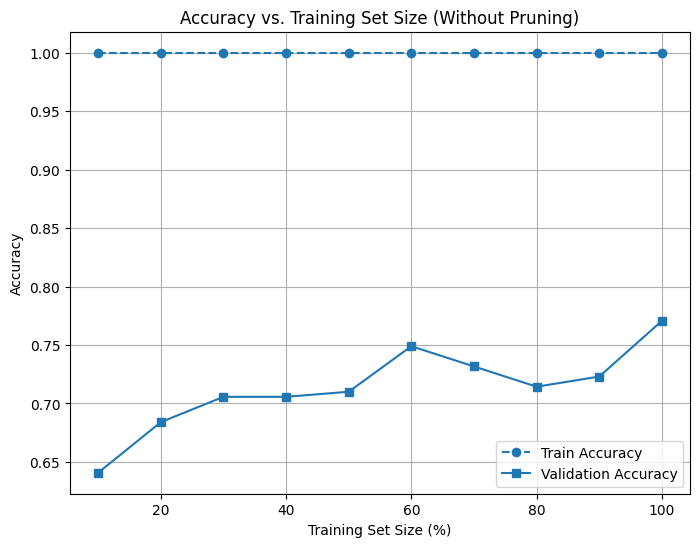

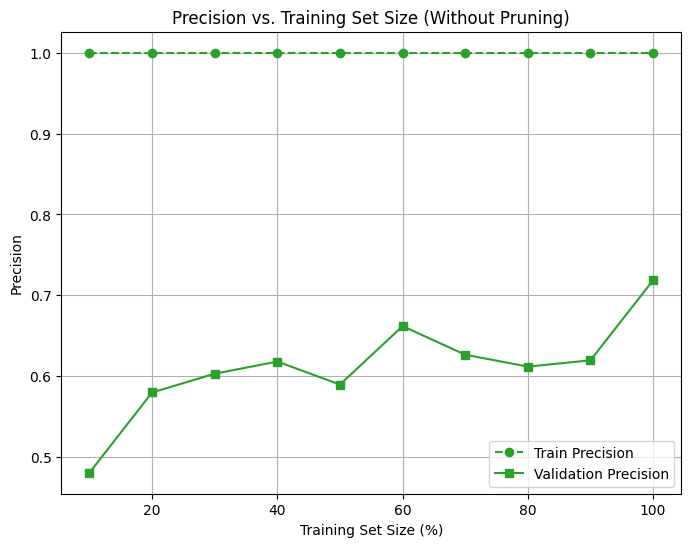

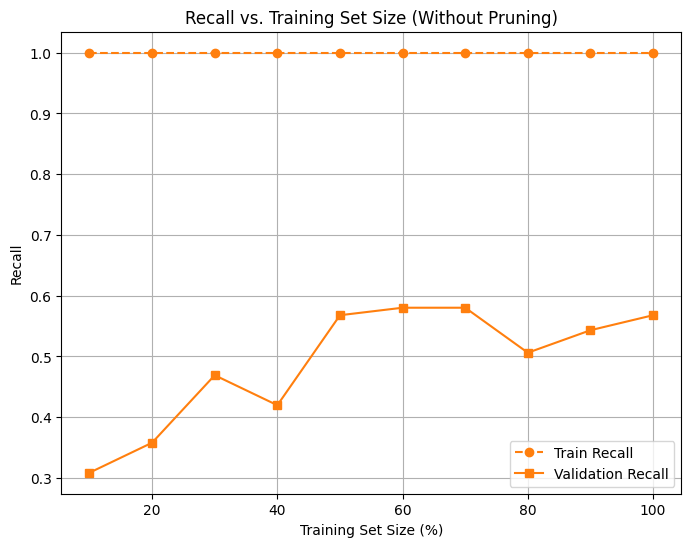

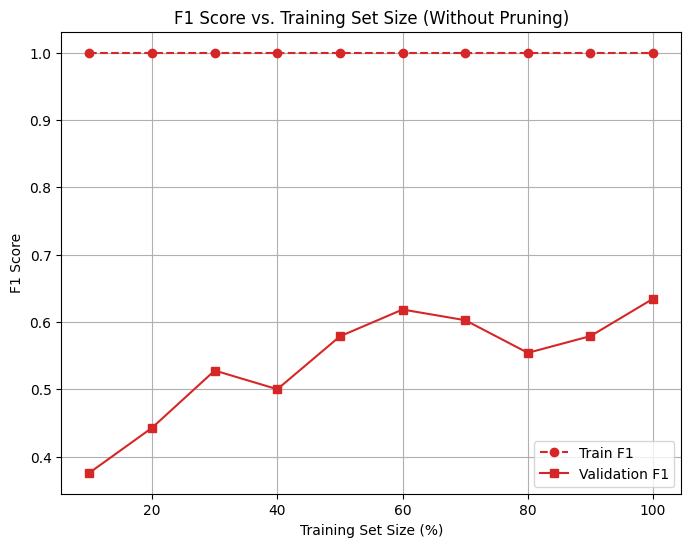

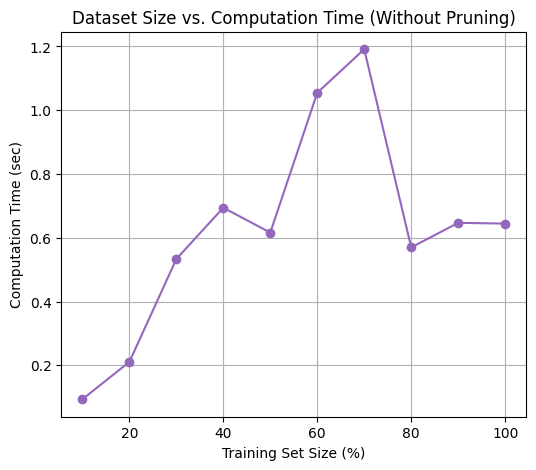

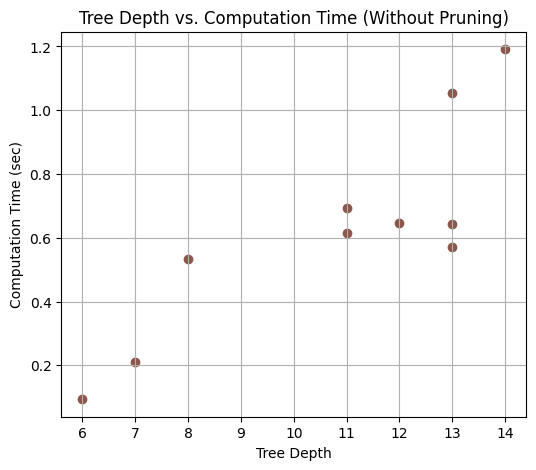

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

########################################
# Data Preprocessing for Diabetes Dataset
########################################
df = pd.read_csv('/content/diabetes.csv')
print("Dataset shape:", df.shape)
print(df.head())

# Assume target column is "Outcome"
X = df.drop(columns=['Outcome'], axis=1)
y = df['Outcome']

# (For diabetes, the features are numeric already. If any categorical, encode them)
# Here we standardize numerical features.
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split into training and validation sets (using stratify to keep class distribution)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

########################################
# Decision Tree Without Pruning Implementation
########################################
class Node:
    def __init__(self, is_leaf=False, prediction=None, feature_index=None, threshold=None, left=None, right=None, samples=None):
        # 'samples' stores a tuple: (unique_values, counts) of training labels at this node.
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.samples = samples

def gini(y):
    classes = np.unique(y)
    impurity = 1.0
    for cls in classes:
        p = np.sum(y == cls) / len(y)
        impurity -= p**2
    return impurity

def best_split(X, y):
    best_feature, best_threshold, best_gain = None, None, 0
    current_impurity = gini(y)
    n_samples, n_features = X.shape
    if n_samples <= 1:
        return None, None, 0
    for feature_index in range(n_features):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            left_mask = X[:, feature_index] <= threshold
            right_mask = X[:, feature_index] > threshold
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue
            y_left = y[left_mask]
            y_right = y[right_mask]
            impurity_left = gini(y_left)
            impurity_right = gini(y_right)
            n_left = len(y_left)
            n_right = len(y_right)
            weighted_impurity = (n_left / n_samples) * impurity_left + (n_right / n_samples) * impurity_right
            gain = current_impurity - weighted_impurity
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_index
                best_threshold = threshold
    return best_feature, best_threshold, best_gain

def build_tree(X, y, min_samples_split=2):
    n_samples = X.shape[0]
    values, counts = np.unique(y, return_counts=True)
    majority_class = values[np.argmax(counts)]
    node = Node(samples=(values, counts))
    if n_samples < min_samples_split or gini(y) == 0:
        node.is_leaf = True
        node.prediction = majority_class
        return node
    feature, threshold, gain = best_split(X, y)
    if gain == 0 or feature is None:
        node.is_leaf = True
        node.prediction = majority_class
        return node
    node.feature_index = feature
    node.threshold = threshold
    left_mask = X[:, feature] <= threshold
    right_mask = X[:, feature] > threshold
    node.left = build_tree(X[left_mask], y[left_mask], min_samples_split)
    node.right = build_tree(X[right_mask], y[right_mask], min_samples_split)
    return node

def tree_predict(node, x):
    if node.is_leaf:
        return node.prediction
    if x[node.feature_index] <= node.threshold:
        return tree_predict(node.left, x)
    else:
        return tree_predict(node.right, x)

class DecisionTreeWithoutPruning:
    def __init__(self, min_samples_split=2):
        self.min_samples_split = min_samples_split
        self.root = None
        self.train_time = None

    def fit(self, X, y):
        X_np = X.values if isinstance(X, pd.DataFrame) else X
        y_np = y.values if isinstance(y, pd.Series) else y
        start = time.time()
        self.root = build_tree(X_np, y_np, self.min_samples_split)
        self.train_time = time.time() - start

    def predict(self, X):
        X_np = X.values if isinstance(X, pd.DataFrame) else X
        return np.array([tree_predict(self.root, x) for x in X_np])

# Helper function to compute tree depth.
def compute_depth(node):
    if node.is_leaf:
        return 1
    return 1 + max(compute_depth(node.left), compute_depth(node.right))

########################################
# Experiment: Varying Dataset Size for Decision Tree Without Pruning
########################################
train_fracs = np.linspace(0.1, 1.0, 10)

# Dictionaries to store performance metrics and computation info.
dt_results = {
    'train_acc': [],
    'val_acc': [],
    'train_prec': [],
    'val_prec': [],
    'train_rec': [],
    'val_rec': [],
    'train_f1': [],
    'val_f1': [],
    'train_time': [],
    'tree_depth': []
}

for frac in train_fracs:
    idx = int(frac * len(X_train))
    X_train_frac = X_train.iloc[:idx]
    y_train_frac = y_train.iloc[:idx]

    dt = DecisionTreeWithoutPruning(min_samples_split=2)
    start = time.time()
    dt.fit(X_train_frac, y_train_frac)
    total_time = time.time() - start
    dt_results['train_time'].append(total_time)
    depth = compute_depth(dt.root)
    dt_results['tree_depth'].append(depth)

    preds_train = dt.predict(X_train_frac)
    preds_val = dt.predict(X_val)

    t_acc = accuracy_score(y_train_frac, preds_train)
    v_acc = accuracy_score(y_val, preds_val)
    t_prec = precision_score(y_train_frac, preds_train, average='binary', pos_label=1, zero_division=0)
    v_prec = precision_score(y_val, preds_val, average='binary', pos_label=1, zero_division=0)
    t_rec = recall_score(y_train_frac, preds_train, average='binary', pos_label=1, zero_division=0)
    v_rec = recall_score(y_val, preds_val, average='binary', pos_label=1, zero_division=0)
    t_f1 = f1_score(y_train_frac, preds_train, average='binary', pos_label=1, zero_division=0)
    v_f1 = f1_score(y_val, preds_val, average='binary', pos_label=1, zero_division=0)

    dt_results['train_acc'].append(t_acc)
    dt_results['val_acc'].append(v_acc)
    dt_results['train_prec'].append(t_prec)
    dt_results['val_prec'].append(v_prec)
    dt_results['train_rec'].append(t_rec)
    dt_results['val_rec'].append(v_rec)
    dt_results['train_f1'].append(t_f1)
    dt_results['val_f1'].append(v_f1)

    print(f"Frac: {frac:.2f} => Time: {total_time:.4f} sec, Depth: {depth}")
    print(f"  Train Acc: {t_acc:.4f}, Val Acc: {v_acc:.4f}")
    print(f"  Train Prec: {t_prec:.4f}, Val Prec: {v_prec:.4f}")
    print(f"  Train Rec: {t_rec:.4f}, Val Rec: {v_rec:.4f}")
    print(f"  Train F1: {t_f1:.4f}, Val F1: {v_f1:.4f}\n")

########################################
# Plotting for Decision Tree Without Pruning
########################################

# 1) Training vs. Validation Accuracy
plt.figure(figsize=(8,6))
plt.plot(train_fracs*100, dt_results['train_acc'], marker='o', linestyle='--', color='tab:blue', label='Train Accuracy')
plt.plot(train_fracs*100, dt_results['val_acc'], marker='s', color='tab:blue', label='Validation Accuracy')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Training Set Size (Without Pruning)')
plt.legend()
plt.grid(True)
plt.show()

# 2) Training vs. Validation Precision
plt.figure(figsize=(8,6))
plt.plot(train_fracs*100, dt_results['train_prec'], marker='o', linestyle='--', color='tab:green', label='Train Precision')
plt.plot(train_fracs*100, dt_results['val_prec'], marker='s', color='tab:green', label='Validation Precision')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Precision')
plt.title('Precision vs. Training Set Size (Without Pruning)')
plt.legend()
plt.grid(True)
plt.show()

# 3) Training vs. Validation Recall
plt.figure(figsize=(8,6))
plt.plot(train_fracs*100, dt_results['train_rec'], marker='o', linestyle='--', color='tab:orange', label='Train Recall')
plt.plot(train_fracs*100, dt_results['val_rec'], marker='s', color='tab:orange', label='Validation Recall')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Recall')
plt.title('Recall vs. Training Set Size (Without Pruning)')
plt.legend()
plt.grid(True)
plt.show()

# 4) Training vs. Validation F1 Score
plt.figure(figsize=(8,6))
plt.plot(train_fracs*100, dt_results['train_f1'], marker='o', linestyle='--', color='tab:red', label='Train F1')
plt.plot(train_fracs*100, dt_results['val_f1'], marker='s', color='tab:red', label='Validation F1')
plt.xlabel('Training Set Size (%)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Training Set Size (Without Pruning)')
plt.legend()
plt.grid(True)
plt.show()

# 5) Training Time vs. Dataset Size
plt.figure(figsize=(6,5))
plt.plot(train_fracs*100, dt_results['train_time'], marker='o', color='tab:purple')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Computation Time (sec)')
plt.title('Dataset Size vs. Computation Time (Without Pruning)')
plt.grid(True)
plt.show()

# 6) Training Time vs. Tree Depth
plt.figure(figsize=(6,5))
plt.scatter(dt_results['tree_depth'], dt_results['train_time'], color='tab:brown')
plt.xlabel('Tree Depth')
plt.ylabel('Computation Time (sec)')
plt.title('Tree Depth vs. Computation Time (Without Pruning)')
plt.grid(True)
plt.show()


Dataset shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Training set shape: (537, 8)
Validation set shape: (231, 8)
Frac: 0.10 => Time: 0.0842 sec, Depth: 2
  Train Acc: 0.8491, Val Acc: 0.7056
  Train Prec: 0.7143, Val Prec: 0.5802
  Train Rec: 0.8824, Val Rec: 0.5802
  Train F1: 0.7895, Val F1: 0.5802

Frac: 0.20 => Time: 0.2370 se

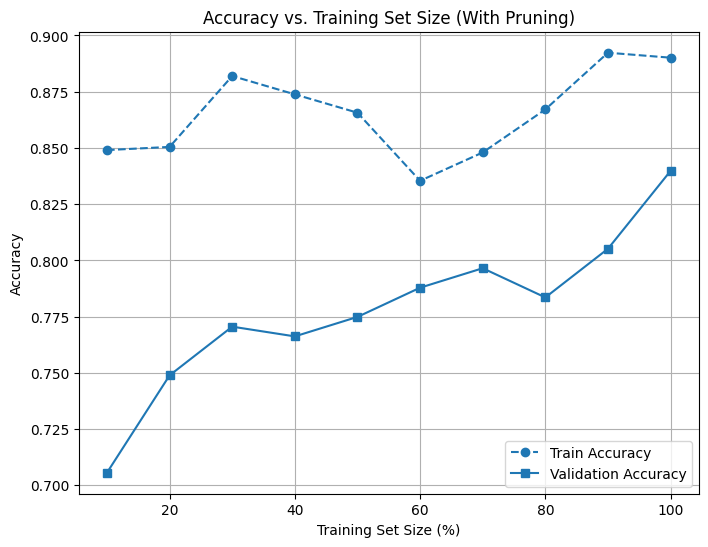

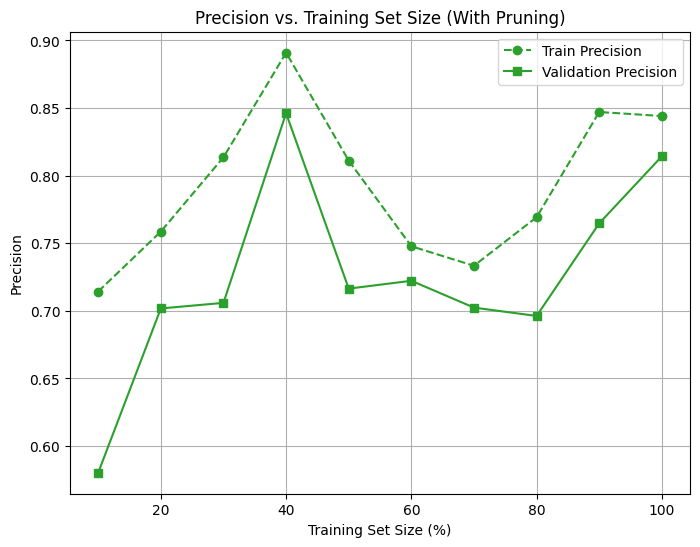

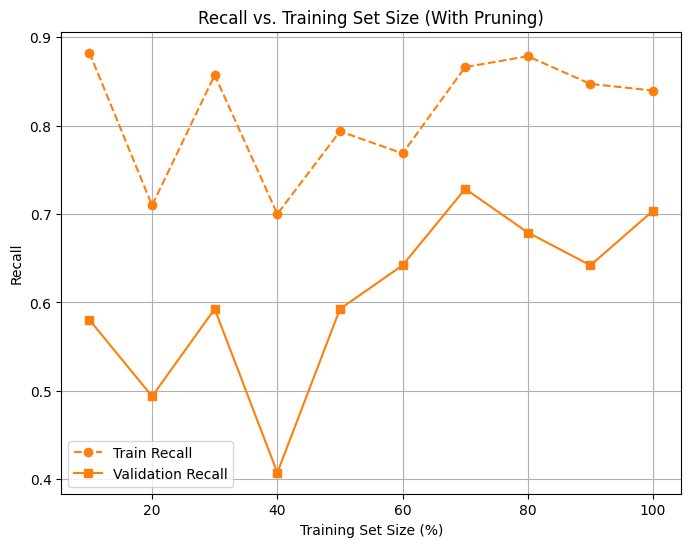

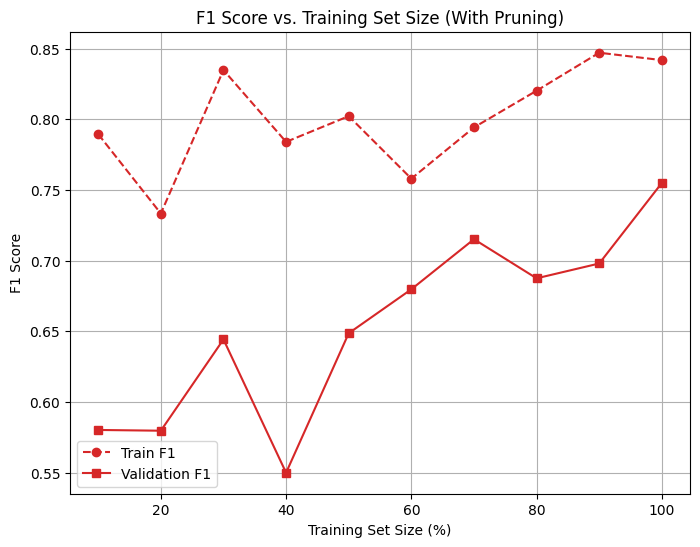

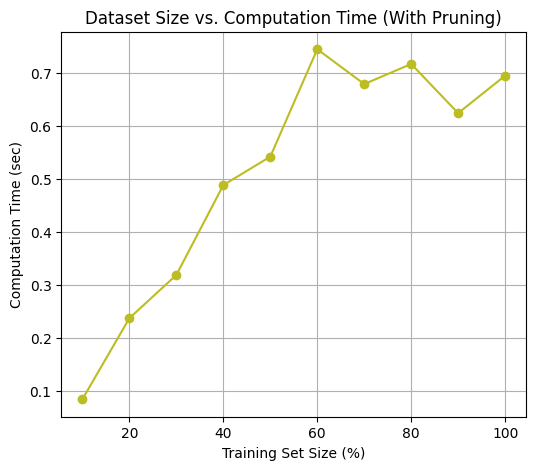

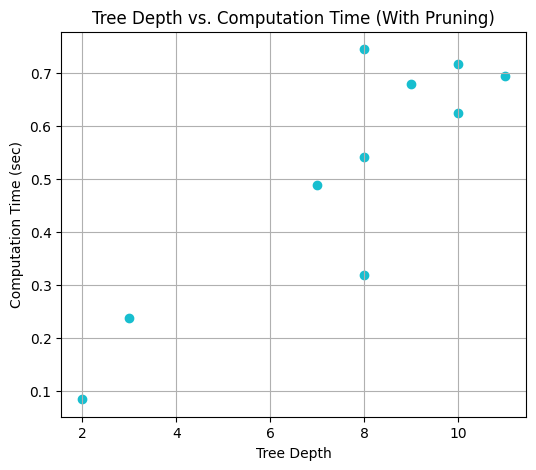

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

########################################
# Data Preprocessing for Diabetes Dataset
########################################
df = pd.read_csv('/content/diabetes.csv')
print("Dataset shape:", df.shape)
print(df.head())

# Assume target column is "Outcome"
X = df.drop(columns=['Outcome'], axis=1)
y = df['Outcome']

# Standardize numerical features (diabetes dataset is numeric)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data (using stratify for class balance)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

########################################
# Decision Tree With Pruning Implementation
########################################
class Node:
    def __init__(self, is_leaf=False, prediction=None, feature_index=None, threshold=None, left=None, right=None, samples=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.samples = samples

def gini(y):
    classes = np.unique(y)
    impurity = 1.0
    for cls in classes:
        p = np.sum(y == cls) / len(y)
        impurity -= p**2
    return impurity

def best_split(X, y):
    best_feature, best_threshold, best_gain = None, None, 0
    current_impurity = gini(y)
    n_samples, n_features = X.shape
    if n_samples <= 1:
        return None, None, 0
    for feature_index in range(n_features):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            left_mask = X[:, feature_index] <= threshold
            right_mask = X[:, feature_index] > threshold
            if np.sum(left_mask)==0 or np.sum(right_mask)==0:
                continue
            y_left = y[left_mask]
            y_right = y[right_mask]
            impurity_left = gini(y_left)
            impurity_right = gini(y_right)
            n_left = len(y_left)
            n_right = len(y_right)
            weighted_impurity = (n_left/n_samples)*impurity_left + (n_right/n_samples)*impurity_right
            gain = current_impurity - weighted_impurity
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_index
                best_threshold = threshold
    return best_feature, best_threshold, best_gain

def build_tree(X, y, min_samples_split=2):
    n_samples = X.shape[0]
    values, counts = np.unique(y, return_counts=True)
    majority_class = values[np.argmax(counts)]
    node = Node(samples=(values, counts))
    if n_samples < min_samples_split or gini(y)==0:
        node.is_leaf = True
        node.prediction = majority_class
        return node
    feature, threshold, gain = best_split(X, y)
    if gain==0 or feature is None:
        node.is_leaf = True
        node.prediction = majority_class
        return node
    node.feature_index = feature
    node.threshold = threshold
    left_mask = X[:, feature] <= threshold
    right_mask = X[:, feature] > threshold
    node.left = build_tree(X[left_mask], y[left_mask], min_samples_split)
    node.right = build_tree(X[right_mask], y[right_mask], min_samples_split)
    return node

def tree_predict(node, x):
    if node.is_leaf:
        return node.prediction
    if x[node.feature_index] <= node.threshold:
        return tree_predict(node.left, x)
    else:
        return tree_predict(node.right, x)

def prune_tree(node, X_val, y_val):
    if node.is_leaf or len(X_val) == 0:
        return node
    feature = node.feature_index
    threshold = node.threshold
    left_mask = X_val[:, feature] <= threshold
    right_mask = X_val[:, feature] > threshold
    node.left = prune_tree(node.left, X_val[left_mask], y_val[left_mask])
    node.right = prune_tree(node.right, X_val[right_mask], y_val[right_mask])
    subtree_preds = np.array([tree_predict(node, x) for x in X_val])
    subtree_acc = np.mean(subtree_preds == y_val)
    values, counts = node.samples
    majority_class = values[np.argmax(counts)]
    leaf_preds = np.full(shape=len(y_val), fill_value=majority_class)
    leaf_acc = np.mean(leaf_preds == y_val)
    if leaf_acc >= subtree_acc:
        pruned_node = Node(is_leaf=True, prediction=majority_class, samples=node.samples)
        return pruned_node
    else:
        return node

class DecisionTreeWithPruning:
    def __init__(self, min_samples_split=2):
        self.min_samples_split = min_samples_split
        self.root = None
        self.train_time = None

    def fit(self, X, y, X_val, y_val):
        X_np = X.values if isinstance(X, pd.DataFrame) else X
        y_np = y.values if isinstance(y, pd.Series) else y
        start = time.time()
        self.root = build_tree(X_np, y_np, self.min_samples_split)
        build_time = time.time() - start
        X_val_np = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
        y_val_np = y_val.values if isinstance(y_val, pd.Series) else y_val
        self.root = prune_tree(self.root, X_val_np, y_val_np)
        self.train_time = build_time

    def predict(self, X):
        X_np = X.values if isinstance(X, pd.DataFrame) else X
        return np.array([tree_predict(self.root, x) for x in X_np])

def compute_depth(node):
    if node.is_leaf:
        return 1
    return 1 + max(compute_depth(node.left), compute_depth(node.right))

########################################
# Experiment: Varying Dataset Size for Decision Tree With Pruning
########################################
train_fracs = np.linspace(0.1, 1.0, 10)
dtp_results = {
    'train_acc': [],
    'val_acc': [],
    'train_prec': [],
    'val_prec': [],
    'train_rec': [],
    'val_rec': [],
    'train_f1': [],
    'val_f1': [],
    'train_time': [],
    'tree_depth': []
}

for frac in train_fracs:
    idx = int(frac * len(X_train))
    X_train_frac = X_train.iloc[:idx]
    y_train_frac = y_train.iloc[:idx]

    dtp = DecisionTreeWithPruning(min_samples_split=2)
    start = time.time()
    dtp.fit(X_train_frac, y_train_frac, X_val, y_val)
    total_time = time.time() - start
    dtp_results['train_time'].append(total_time)
    depth = compute_depth(dtp.root)
    dtp_results['tree_depth'].append(depth)

    preds_train = dtp.predict(X_train_frac)
    preds_val = dtp.predict(X_val)

    t_acc = accuracy_score(y_train_frac, preds_train)
    v_acc = accuracy_score(y_val, preds_val)
    t_prec = precision_score(y_train_frac, preds_train, average='binary', pos_label=1, zero_division=0)
    v_prec = precision_score(y_val, preds_val, average='binary', pos_label=1, zero_division=0)
    t_rec = recall_score(y_train_frac, preds_train, average='binary', pos_label=1, zero_division=0)
    v_rec = recall_score(y_val, preds_val, average='binary', pos_label=1, zero_division=0)
    t_f1 = f1_score(y_train_frac, preds_train, average='binary', pos_label=1, zero_division=0)
    v_f1 = f1_score(y_val, preds_val, average='binary', pos_label=1, zero_division=0)

    dtp_results['train_acc'].append(t_acc)
    dtp_results['val_acc'].append(v_acc)
    dtp_results['train_prec'].append(t_prec)
    dtp_results['val_prec'].append(v_prec)
    dtp_results['train_rec'].append(t_rec)
    dtp_results['val_rec'].append(v_rec)
    dtp_results['train_f1'].append(t_f1)
    dtp_results['val_f1'].append(v_f1)

    print(f"Frac: {frac:.2f} => Time: {total_time:.4f} sec, Depth: {depth}")
    print(f"  Train Acc: {t_acc:.4f}, Val Acc: {v_acc:.4f}")
    print(f"  Train Prec: {t_prec:.4f}, Val Prec: {v_prec:.4f}")
    print(f"  Train Rec: {t_rec:.4f}, Val Rec: {v_rec:.4f}")
    print(f"  Train F1: {t_f1:.4f}, Val F1: {v_f1:.4f}\n")

########################################
# Plotting for Decision Tree With Pruning
########################################

# 1) Accuracy
plt.figure(figsize=(8,6))
plt.plot(train_fracs*100, dtp_results['train_acc'], marker='o', linestyle='--', color='tab:blue', label='Train Accuracy')
plt.plot(train_fracs*100, dtp_results['val_acc'], marker='s', color='tab:blue', label='Validation Accuracy')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Training Set Size (With Pruning)')
plt.legend()
plt.grid(True)
plt.show()

# 2) Precision
plt.figure(figsize=(8,6))
plt.plot(train_fracs*100, dtp_results['train_prec'], marker='o', linestyle='--', color='tab:green', label='Train Precision')
plt.plot(train_fracs*100, dtp_results['val_prec'], marker='s', color='tab:green', label='Validation Precision')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Precision')
plt.title('Precision vs. Training Set Size (With Pruning)')
plt.legend()
plt.grid(True)
plt.show()

# 3) Recall
plt.figure(figsize=(8,6))
plt.plot(train_fracs*100, dtp_results['train_rec'], marker='o', linestyle='--', color='tab:orange', label='Train Recall')
plt.plot(train_fracs*100, dtp_results['val_rec'], marker='s', color='tab:orange', label='Validation Recall')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Recall')
plt.title('Recall vs. Training Set Size (With Pruning)')
plt.legend()
plt.grid(True)
plt.show()

# 4) F1 Score
plt.figure(figsize=(8,6))
plt.plot(train_fracs*100, dtp_results['train_f1'], marker='o', linestyle='--', color='tab:red', label='Train F1')
plt.plot(train_fracs*100, dtp_results['val_f1'], marker='s', color='tab:red', label='Validation F1')
plt.xlabel('Training Set Size (%)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Training Set Size (With Pruning)')
plt.legend()
plt.grid(True)
plt.show()

# 5) Dataset Size vs. Computation Time
plt.figure(figsize=(6,5))
plt.plot(train_fracs*100, dtp_results['train_time'], marker='o', color='tab:olive')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Computation Time (sec)')
plt.title('Dataset Size vs. Computation Time (With Pruning)')
plt.grid(True)
plt.show()

# 6) Tree Depth vs. Computation Time
plt.figure(figsize=(6,5))
plt.scatter(dtp_results['tree_depth'], dtp_results['train_time'], color='tab:cyan')
plt.xlabel('Tree Depth')
plt.ylabel('Computation Time (sec)')
plt.title('Tree Depth vs. Computation Time (With Pruning)')
plt.grid(True)
plt.show()


Dataset shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Training set shape: (537, 8)
Validation set shape: (231, 8)

Training fraction: 0.10 (n = 53)
  Custom SVM: Train Acc=0.7925, Val Acc=0.7403, Time=1.2962 sec
  SVC Linear: Train Acc=0.8679, Val Acc=0.7489, Time=0.0034 sec
  SVC RBF: Train Acc=0.9245, Val Acc=0.6970, Time=0.0034 

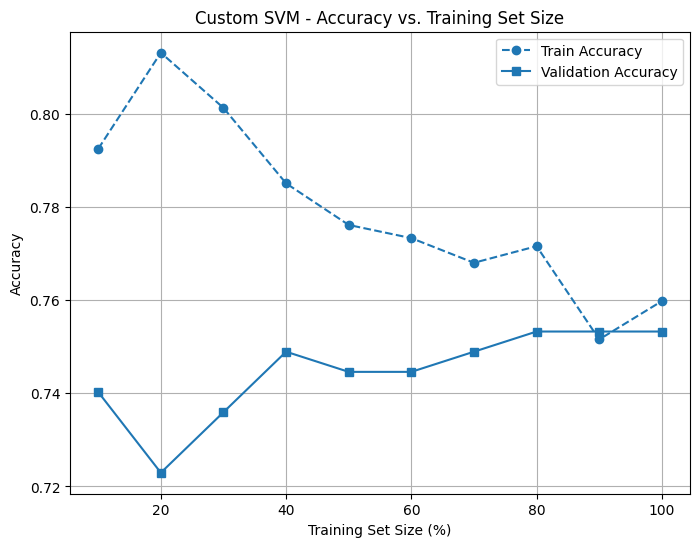

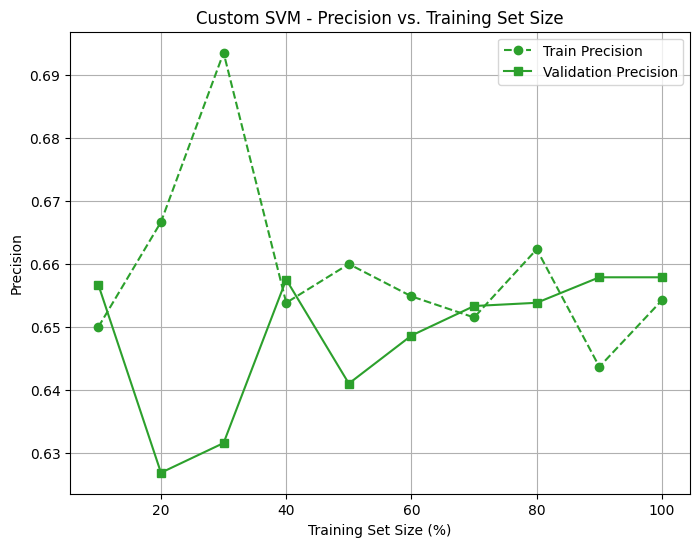

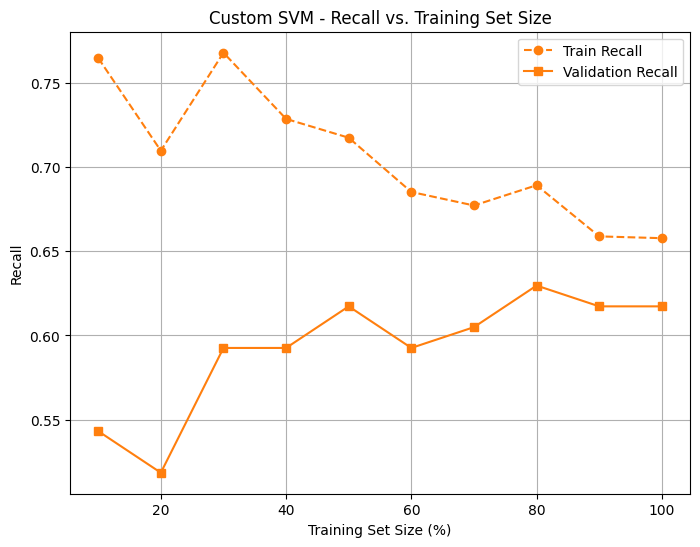

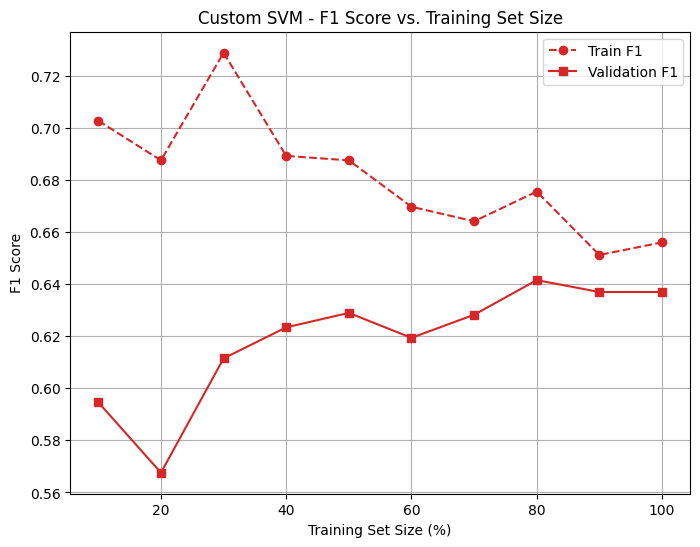

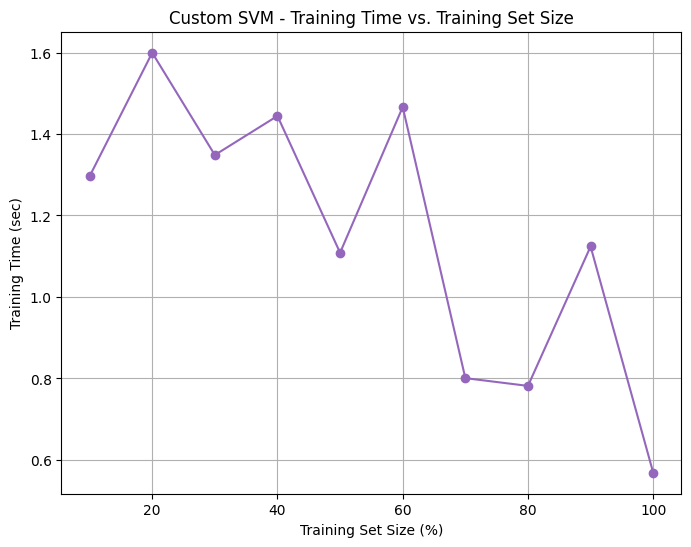

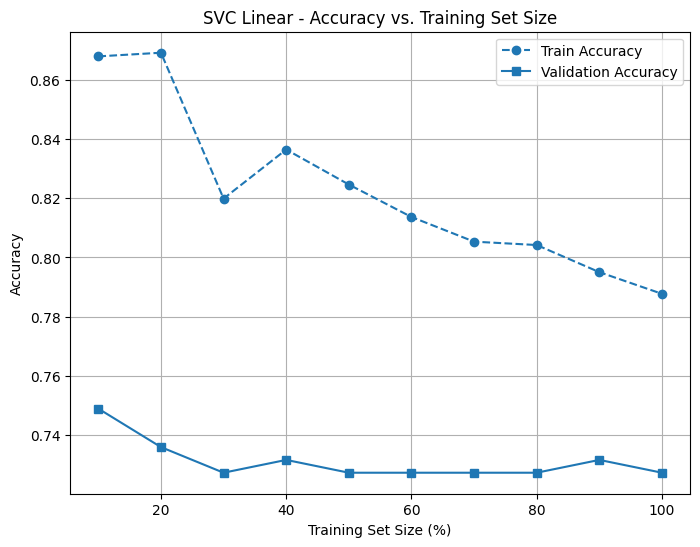

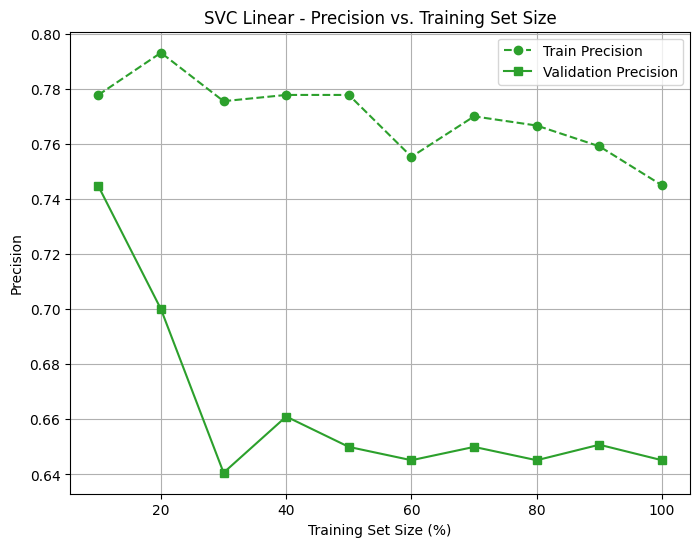

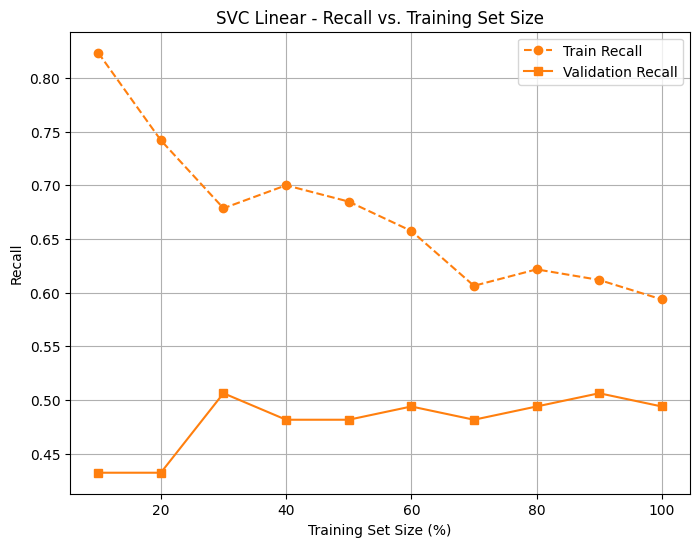

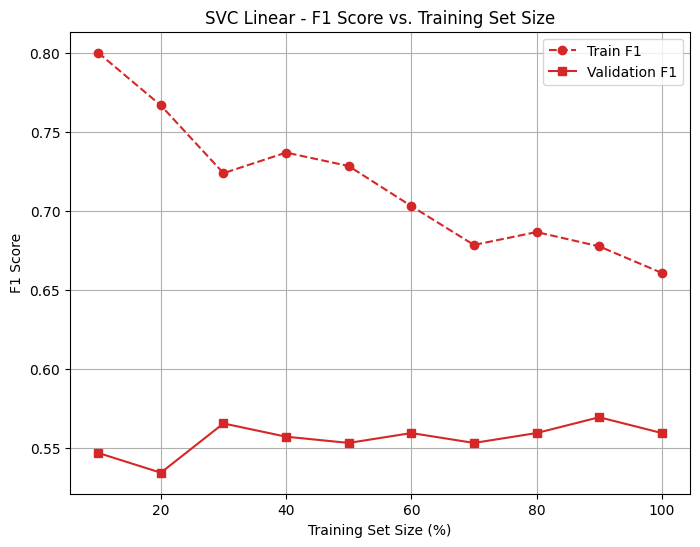

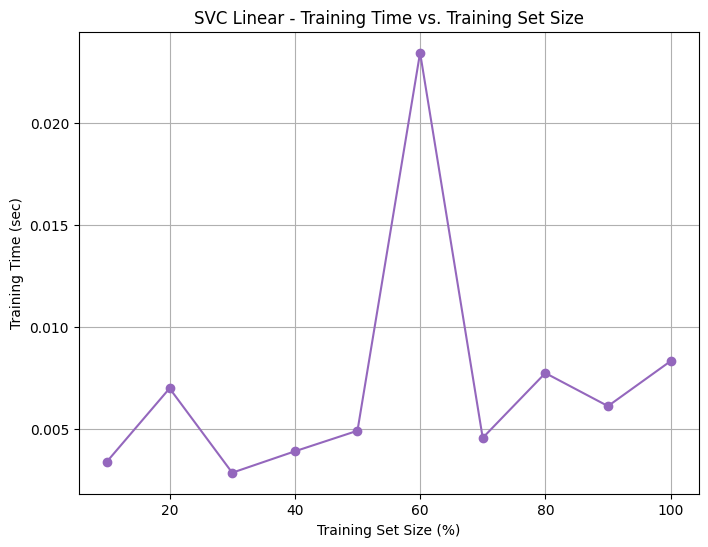

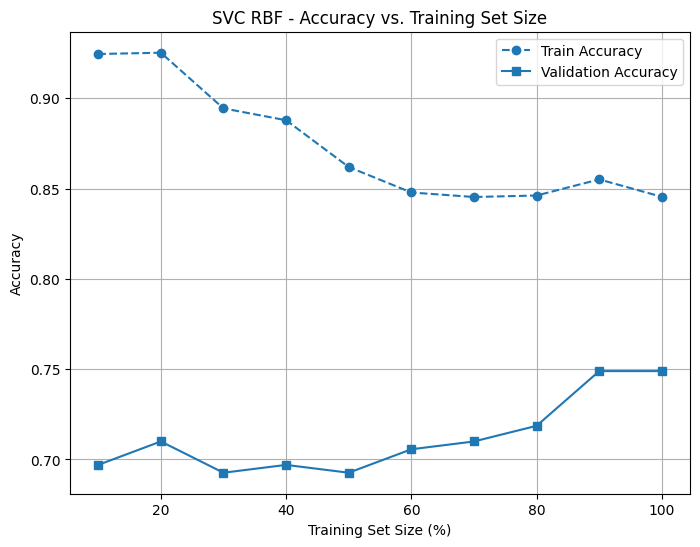

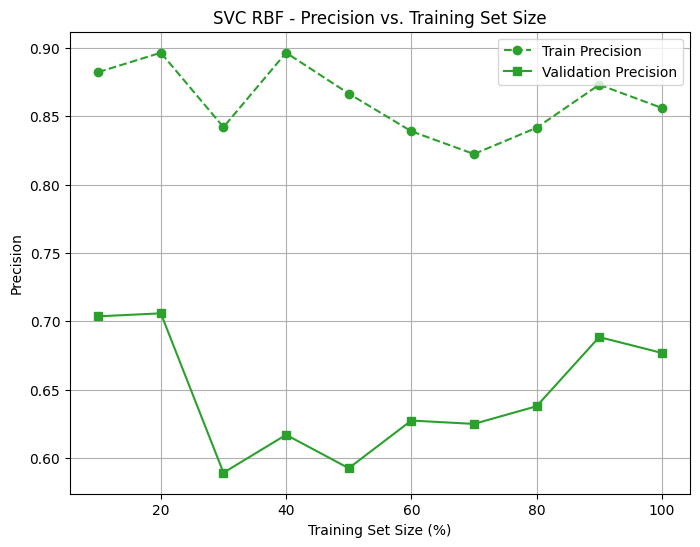

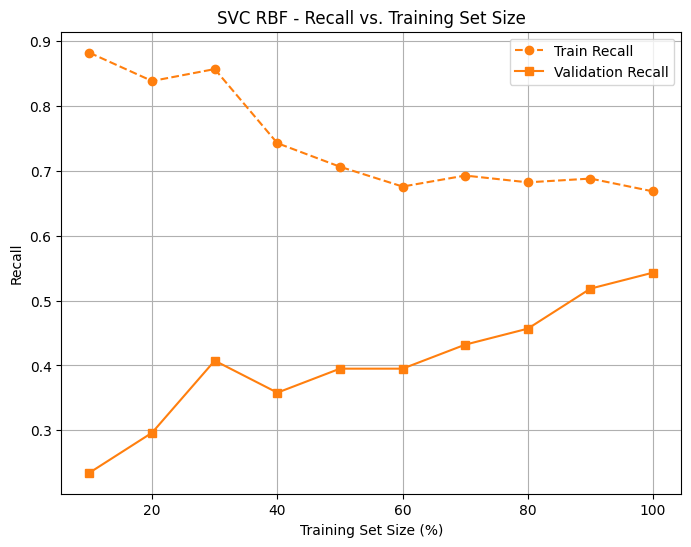

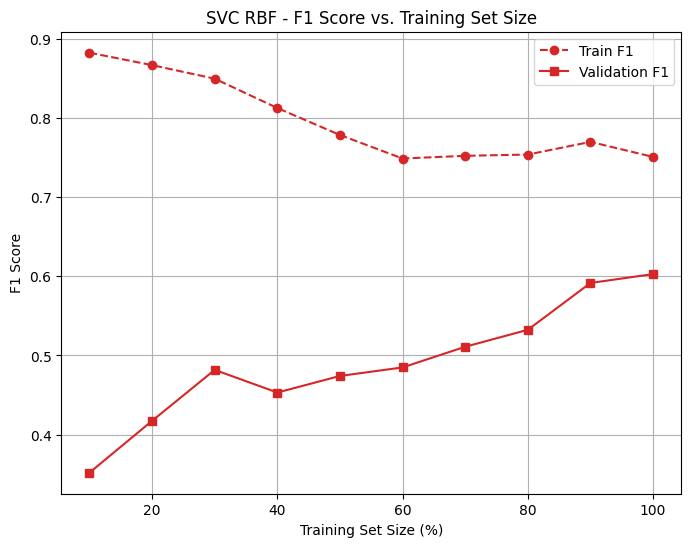

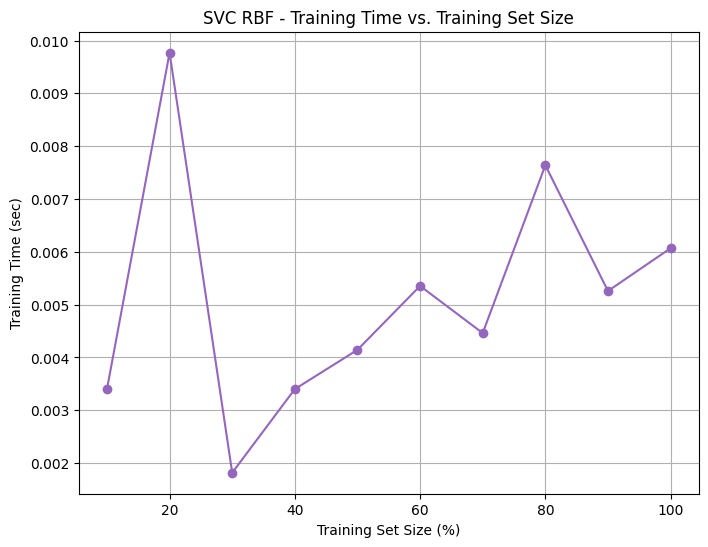

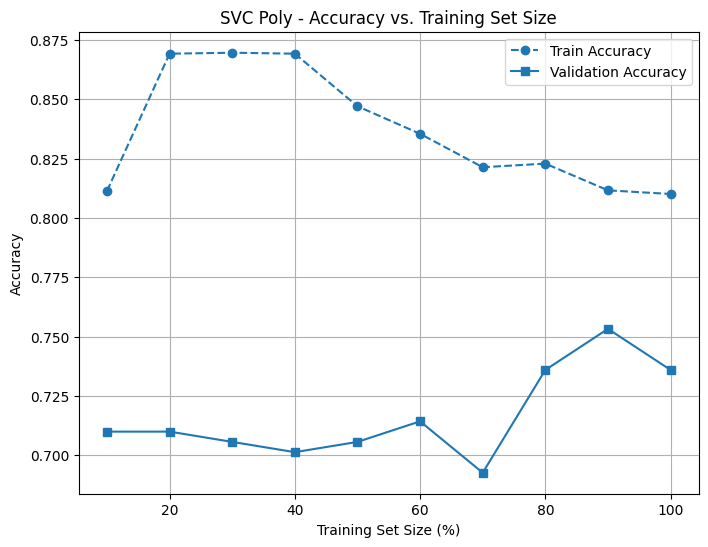

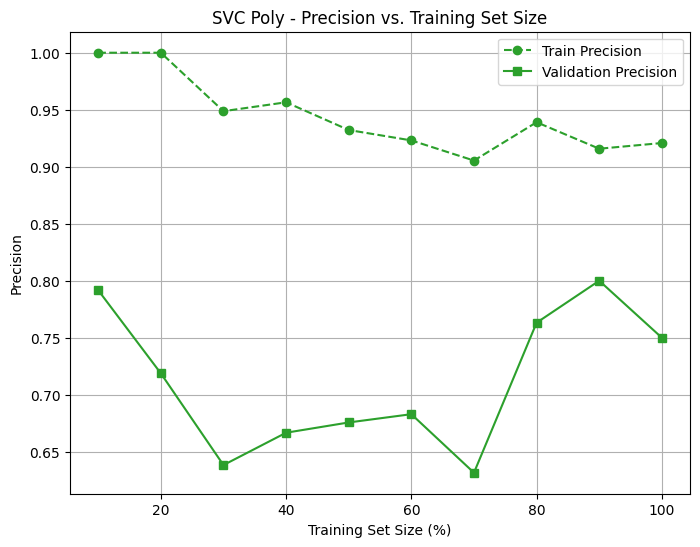

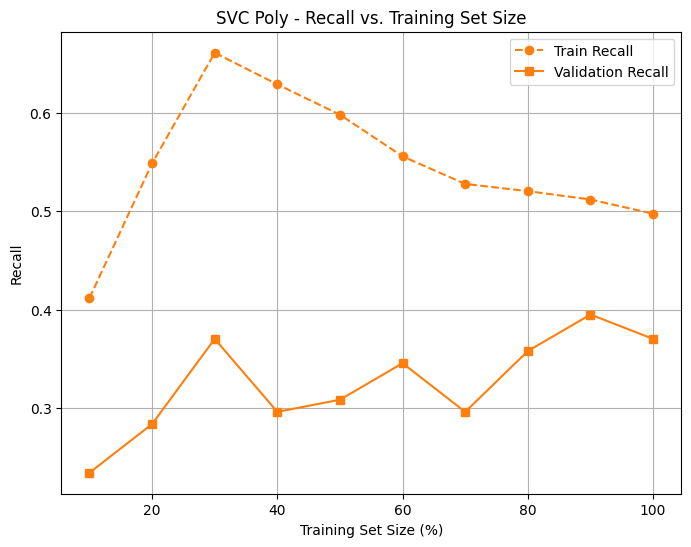

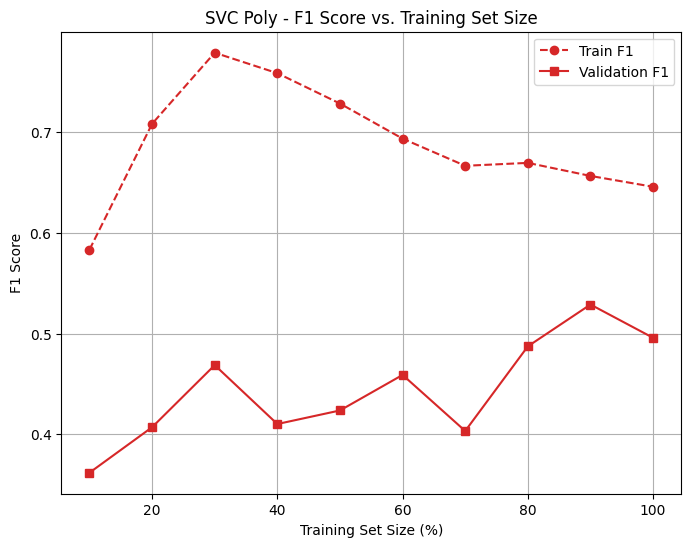

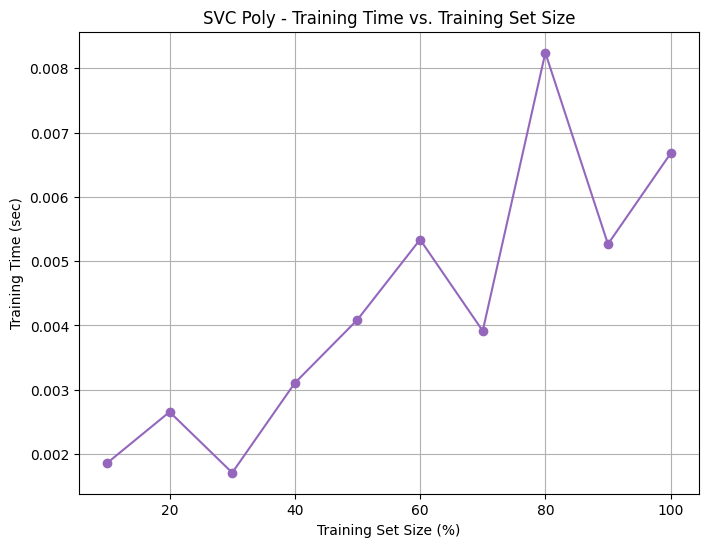

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC

########################################
# Data Preprocessing for Diabetes Dataset
########################################
df = pd.read_csv('/content/diabetes.csv')
print("Dataset shape:", df.shape)
print(df.head())

# Assume target column is "Outcome"
X = df.drop(columns=['Outcome'], axis=1)
y = df['Outcome']

# For diabetes, features are numeric; standardize them.
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Convert target labels to numeric (if not already numeric)
# (Diabetes dataset usually has 0 and 1, so we assume that.)
y_encoded = y  # already numeric

# Split into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

########################################
# SVM from Scratch (Custom Linear SVM)
########################################
class SVMFromScratch:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.loss_history = []

    def fit(self, X, y):
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y if isinstance(y, np.ndarray) else y.values
        n_samples, n_features = X.shape
        # Convert labels to -1 and 1.
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0
        for i in range(self.n_iters):
            margins = y_ * (np.dot(X, self.w) + self.b)
            loss_hinge = np.maximum(0, 1 - margins)
            loss = 0.5 * self.lambda_param * np.dot(self.w, self.w) + np.mean(loss_hinge)
            self.loss_history.append(loss)
            indicator = (loss_hinge > 0).astype(float)
            grad_w = self.lambda_param * self.w - np.dot(X.T, y_ * indicator) / n_samples
            grad_b = -np.sum(y_ * indicator) / n_samples
            self.w -= self.learning_rate * grad_w
            self.b -= self.learning_rate * grad_b

    def predict(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        linear_output = np.dot(X, self.w) + self.b
        return np.where(linear_output >= 0, 1, 0)

########################################
# Experiment Setup for SVM
########################################
train_fracs = np.linspace(0.1, 1.0, 10)

# Define methods: Custom SVM and SVC with different kernels.
methods = {
    'Custom SVM': {
        'model': SVMFromScratch,
        'params': {'learning_rate': 0.00001, 'lambda_param': 0.01, 'n_iters': 20000}
    },
    'SVC Linear': {
        'model': lambda: SVC(kernel='linear', C=1.0, random_state=42),
        'params': {}
    },
    'SVC RBF': {
        'model': lambda: SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
        'params': {}
    },
    'SVC Poly': {
        'model': lambda: SVC(kernel='poly', degree=3, C=1.0, gamma='scale', random_state=42),
        'params': {}
    }
}

# Prepare a dictionary to store results per method.
svm_results = {m: {
    'train_acc': [],
    'val_acc': [],
    'train_prec': [],
    'val_prec': [],
    'train_rec': [],
    'val_rec': [],
    'train_f1': [],
    'val_f1': [],
    'train_time': []
} for m in methods.keys()}

for frac in train_fracs:
    idx = int(frac * len(X_train))
    X_train_frac = X_train.iloc[:idx]
    y_train_frac = y_train[:idx]
    print(f"\nTraining fraction: {frac:.2f} (n = {idx})")
    for method_name, method_info in methods.items():
        start_time = time.time()
        if method_name == 'Custom SVM':
            model = method_info['model'](**method_info['params'])
            model.fit(X_train_frac, y_train_frac)
        else:
            model = method_info['model']()
            model.fit(X_train_frac, y_train_frac)
        train_time = time.time() - start_time
        svm_results[method_name]['train_time'].append(train_time)
        preds_train = model.predict(X_train_frac)
        preds_val = model.predict(X_val)
        t_acc = accuracy_score(y_train_frac, preds_train)
        v_acc = accuracy_score(y_val, preds_val)
        t_prec = precision_score(y_train_frac, preds_train, average='binary', zero_division=0)
        v_prec = precision_score(y_val, preds_val, average='binary', zero_division=0)
        t_rec = recall_score(y_train_frac, preds_train, average='binary', zero_division=0)
        v_rec = recall_score(y_val, preds_val, average='binary', zero_division=0)
        t_f1 = f1_score(y_train_frac, preds_train, average='binary', zero_division=0)
        v_f1 = f1_score(y_val, preds_val, average='binary', zero_division=0)
        svm_results[method_name]['train_acc'].append(t_acc)
        svm_results[method_name]['val_acc'].append(v_acc)
        svm_results[method_name]['train_prec'].append(t_prec)
        svm_results[method_name]['val_prec'].append(v_prec)
        svm_results[method_name]['train_rec'].append(t_rec)
        svm_results[method_name]['val_rec'].append(v_rec)
        svm_results[method_name]['train_f1'].append(t_f1)
        svm_results[method_name]['val_f1'].append(v_f1)
        print(f"  {method_name}: Train Acc={t_acc:.4f}, Val Acc={v_acc:.4f}, Time={train_time:.4f} sec")

########################################
# Plotting for Each SVM Method Separately
########################################
for method_name in methods.keys():
    # Accuracy
    plt.figure(figsize=(8,6))
    plt.plot(train_fracs*100, svm_results[method_name]['train_acc'], marker='o', linestyle='--', color='tab:blue', label='Train Accuracy')
    plt.plot(train_fracs*100, svm_results[method_name]['val_acc'], marker='s', color='tab:blue', label='Validation Accuracy')
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('Accuracy')
    plt.title(f'{method_name} - Accuracy vs. Training Set Size')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision
    plt.figure(figsize=(8,6))
    plt.plot(train_fracs*100, svm_results[method_name]['train_prec'], marker='o', linestyle='--', color='tab:green', label='Train Precision')
    plt.plot(train_fracs*100, svm_results[method_name]['val_prec'], marker='s', color='tab:green', label='Validation Precision')
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('Precision')
    plt.title(f'{method_name} - Precision vs. Training Set Size')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Recall
    plt.figure(figsize=(8,6))
    plt.plot(train_fracs*100, svm_results[method_name]['train_rec'], marker='o', linestyle='--', color='tab:orange', label='Train Recall')
    plt.plot(train_fracs*100, svm_results[method_name]['val_rec'], marker='s', color='tab:orange', label='Validation Recall')
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('Recall')
    plt.title(f'{method_name} - Recall vs. Training Set Size')
    plt.legend()
    plt.grid(True)
    plt.show()

    # F1 Score
    plt.figure(figsize=(8,6))
    plt.plot(train_fracs*100, svm_results[method_name]['train_f1'], marker='o', linestyle='--', color='tab:red', label='Train F1')
    plt.plot(train_fracs*100, svm_results[method_name]['val_f1'], marker='s', color='tab:red', label='Validation F1')
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('F1 Score')
    plt.title(f'{method_name} - F1 Score vs. Training Set Size')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Training Time vs. Dataset Size
    plt.figure(figsize=(8,6))
    plt.plot(train_fracs*100, svm_results[method_name]['train_time'], marker='o', color='tab:purple')
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('Training Time (sec)')
    plt.title(f'{method_name} - Training Time vs. Training Set Size')
    plt.grid(True)
    plt.show()
